# Refine Feature Groups into Final Bins

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax
import jax.numpy as jnp

In [3]:
from zotbin.group import load_groups
from zotbin.reweight import reweighted_metrics
from zotbin.binned import load_binned

In [4]:
zedges, fedges, grpidw, zhistw, zsimw = load_groups('groups_20_120_200.npz')

In [5]:
zedges, fedges, grpidn, zhistn, zsimn = load_groups('groups_20_120_200_nowgt.npz')

In [6]:
init_data = load_binned('binned_40.npz')

In [7]:
assert (len(zedges) - 1) % (len(init_data[0]) - 1) == 0
downsampling = (len(zedges) - 1) // (len(init_data[0]) - 1)
print(f'Downsampling by {downsampling}')

Downsampling by 3


In [9]:
def get_score(group_weights, zhist, gals_per_arcmin2=20., fsky=0.25, metric='FOM_DETF_3x2'):
    # Calculate the redshift distribution in each output bin.
    ngrp, nzbin = zhist.shape
    nbin = len(group_weights)
    assert group_weights.shape[1] == ngrp
    zhist_out = group_weights.dot(zhist)
    # Downsample to the redshift binning used for fast reweighted scores.
    zhist_ds =  zhist_out.reshape(nbin, nzbin // downsampling,  downsampling).sum(axis=-1)
    # Calculate the corresponding weights to use.
    w = zhist_ds / zhist.sum()
    # Calculate the metrics for these weights.
    weights = jnp.array([w,  w])
    scores = reweighted_metrics(weights, *init_data[1:], gals_per_arcmin2=gals_per_arcmin2, fsky=fsky, metrics=[metric])
    return scores[metric]

Calculate the normalized dndz for the DC2 and Buzzard datasets using the downsampled binning:

In [40]:
from tomo_challenge import load_redshift

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [43]:
zds = np.asarray(init_data[0])

In [42]:
zdc2 = load_redshift('/media/data2/tomo_challenge_data/ugrizy/training.hdf5')
zbuz = load_redshift('/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5')

In [47]:
dndz_dc2, _ = np.histogram(zdc2, zds)
dndz_dc2 = dndz_dc2 / dndz_dc2.sum()

In [50]:
dndz_buz, _ = np.histogram(zbuz, zds)
dndz_buz = dndz_buz / dndz_buz.sum()

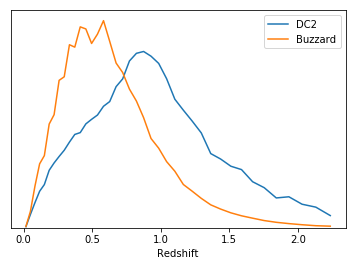

In [53]:
zc = 0.5 * (zds[1:] + zds[:-1])
plt.plot(zc, dndz_dc2, label='DC2')
plt.plot(zc, dndz_buz, label='Buzzard')
plt.xlabel('Redshift')
plt.yticks([])
plt.ylim(0, None)
plt.legend();

## Direct Optimization of the True Reshift Binning

In [56]:
def optimize_weights(dndz, nbin=2, niter=100, eta=0.5, zhist=zhistw, seed=1, gals_per_arcmin2=20., fsky=0.25, metric='FOM_DETF_3x2'):

    dndz = jnp.array(dndz)
    dndz /= dndz.sum()

    # Initialize random weights.
    gen = np.random.RandomState(seed)
    p = jnp.array(gen.normal(size=(nbin, len(dndz))))
    
    @jax.jit
    def get_weights(p):
        w = jnp.exp(p)
        return w / w.sum(axis=0) * dndz
    
    @jax.jit
    def score(p):
        w = get_weights(p)
        weights = jnp.array([w,  w])
        return reweighted_metrics(
            weights, *init_data[1:], gals_per_arcmin2=gals_per_arcmin2, fsky=fsky, metrics=[metric])[metric]

    value_and_score = jax.jit(jax.value_and_grad(score))
    
    scores = []
    max_score = 0
    for it in range(niter):
        score, grads = value_and_score(p)
        scores.append(float(score))
        if scores[-1] > max_score:
            wbest = get_weights(p)
            max_score = scores[-1]
        p = p + eta * grads
        if it % 50 == 0:
            print(it, scores[-1])
    plt.plot(scores)
    plt.show()

    print(f'Max score: {max_score:.3f}.')
    w = np.asarray(wbest)
    ze = init_data[0]
    zc = 0.5 * (ze[1:] + ze[:-1])
    for i in range(nbin):
        plt.fill_between(zc, w[i], alpha=0.4)

    return w, max_score

In [64]:
np.cumsum(w2, axis=0)

array([[1.73290013e-04, 5.27763768e-05, 4.12649661e-03, 1.12058157e-02,
        1.63603723e-02, 2.73794737e-02, 3.22636254e-02, 4.26066443e-02,
        4.37165909e-02, 5.30319512e-02, 5.23254946e-02, 5.81847019e-02,
        5.75333238e-02, 5.31898998e-02, 5.56418449e-02, 5.89501783e-02,
        5.14742173e-02, 4.30243164e-02, 3.74496430e-02, 2.92370152e-02,
        2.07694340e-02, 1.73072109e-03, 2.86871742e-04, 1.87620739e-04,
        1.44320467e-04, 1.26272018e-04, 1.13209826e-04, 9.67849192e-05,
        8.75133483e-05, 1.15141629e-04, 1.00272264e-04, 9.31495961e-05,
        8.36075778e-05, 7.07099389e-05, 7.58868409e-05, 1.88721082e-04,
        7.26090148e-05, 7.35922149e-05, 2.14538188e-04, 8.57964769e-05],
       [3.83167178e-04, 4.75511793e-03, 1.21306702e-02, 1.85666960e-02,
        2.09601521e-02, 3.01167946e-02, 3.28472070e-02, 4.28045653e-02,
        4.38374355e-02, 5.31456396e-02, 5.24473302e-02, 5.83292134e-02,
        5.77320047e-02, 5.35127297e-02, 5.62180020e-02, 6.01328

In [80]:
def get_labels(z, w, seed=1):
    nds = len(zds) - 1
    gen = np.random.RandomState(seed)
    # Assign each redshift to an input redshift bin.
    idx = np.clip(np.digitize(z, zds) - 1, 0, nds - 1)
    # Calculate the CDF for mapping each input bin to output bins.
    cdf = np.cumsum(w, axis=0)
    cdf /= cdf[-1]
    # Loop over input bins to assign output bins sampled from the CDF.
    labels = np.empty(len(z), int)
    for i in range(nds):
        sel = idx == i
        nsel = np.count_nonzero(sel)
        u = gen.uniform(size=nsel)
        labels[sel] = np.searchsorted(cdf[:, i], u)
    return labels
    
labels = get_labels(zbuz[:1000], w5)

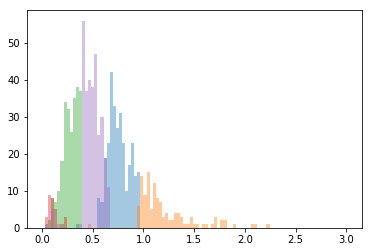

In [82]:
def plot_labels(z, labels):
    nbin = labels.max() + 1
    for i in range(nbin):
        sel = labels == i
        plt.hist(z[sel], bins=np.linspace(0, 3, 100), histtype='stepfilled', alpha=0.4)
        
plot_labels(zbuz[:1000], labels)

0 2.856764793395996
50 38.481788635253906


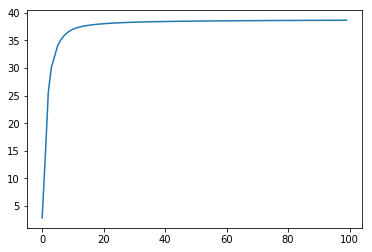

Max score: 38.635.


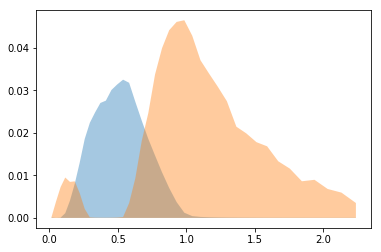

In [58]:
optimize_weights(dndz_dc2, nbin=2, eta=1., niter=100);

0 3.2000186443328857
50 21.976913452148438


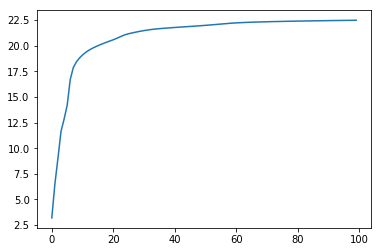

Max score: 22.474.


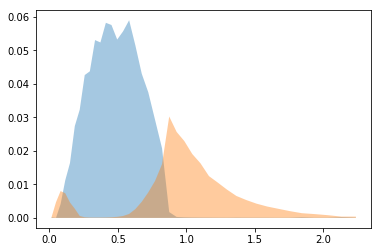

In [57]:
optimize_weights(dndz_buz, nbin=2, eta=1., niter=100);

0 3.2018086910247803
50 21.977750778198242


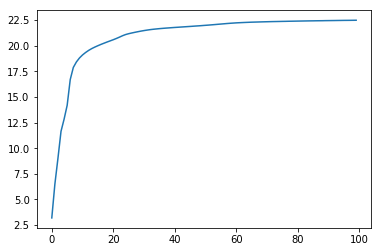

Max score: 22.472.
CPU times: user 3.55 s, sys: 135 ms, total: 3.69 s
Wall time: 3.58 s


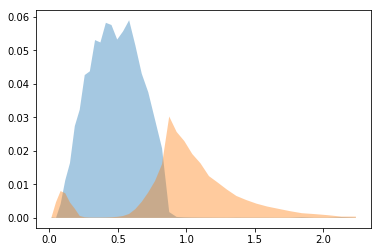

In [28]:
%time w2, m2 = optimize_weights(nbin=2, eta=1., niter=100)

0 6.0063157081604
50 45.33053207397461


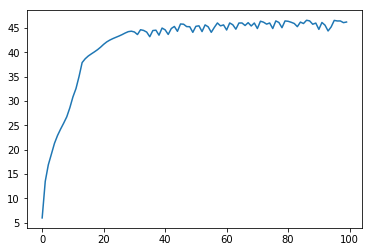

Max score: 46.574.
CPU times: user 7.89 s, sys: 71 ms, total: 7.97 s
Wall time: 7.84 s


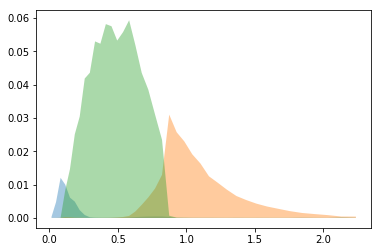

In [29]:
%time w3, m3 = optimize_weights(nbin=3, eta=1., niter=100)

0 8.490499496459961
50 58.03609085083008
100 62.18034744262695
150 62.82968521118164
200 63.00864028930664
250 63.640865325927734
300 65.184814453125
350 64.04039001464844
400 65.45266723632812
450 65.64655303955078


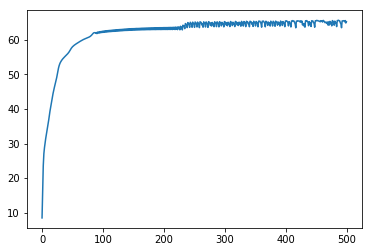

Max score: 65.698.
CPU times: user 1min 17s, sys: 149 ms, total: 1min 17s
Wall time: 1min 17s


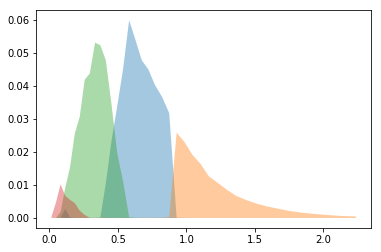

In [32]:
%time w4, m4 = optimize_weights(nbin=4, eta=0.5, niter=500)

0 9.764266967773438
50 62.84239959716797
100 70.74346923828125
150 73.1115493774414
200 72.82343292236328
250 74.05504608154297
300 73.94087982177734
350 74.84740447998047
400 75.19644165039062
450 75.52391052246094


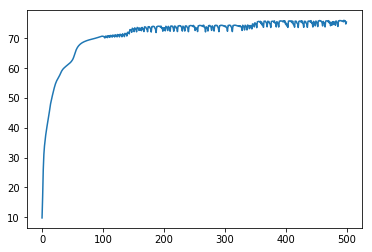

Max score: 76.101.
CPU times: user 2min 56s, sys: 518 ms, total: 2min 57s
Wall time: 2min 57s


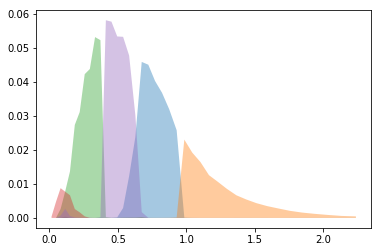

In [33]:
%time w5, m5 = optimize_weights(nbin=5, eta=0.5, niter=500)

0 13.888534545898438
50 68.62844848632812
100 75.19667053222656
150 76.26265716552734
200 77.2719497680664
250 78.62643432617188
300 77.6267318725586
350 79.51612091064453
400 79.62677764892578
450 77.9648208618164


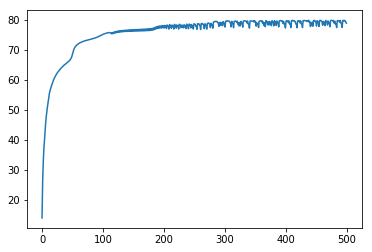

Max score: 79.900.
CPU times: user 5min 49s, sys: 970 ms, total: 5min 50s
Wall time: 5min 50s


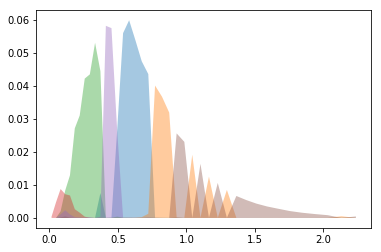

In [34]:
%time w6, m6 = optimize_weights(nbin=6, eta=0.5, niter=500)

0 54.26852035522461
50 75.6591567993164
100 78.65259552001953
150 79.76007080078125


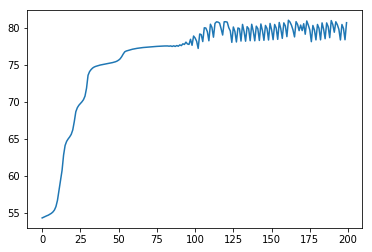

CPU times: user 2min 18s, sys: 616 ms, total: 2min 19s
Wall time: 2min 19s


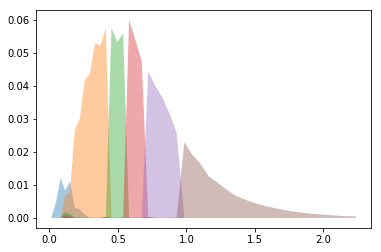

In [88]:
%time w6, m6 = method2_optimize(nbin=6, eta=0.7, niter=200)

0 16.436464309692383
50 84.64531707763672
100 86.92375183105469
150 88.50049591064453
200 88.01998138427734
250 88.68807983398438


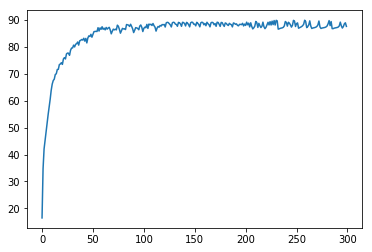

Max score: 89.942.
CPU times: user 6min 28s, sys: 1.22 s, total: 6min 29s
Wall time: 6min 29s


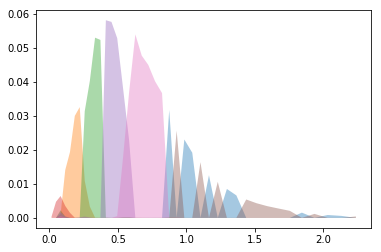

In [35]:
%time w7, m7 = optimize_weights(nbin=7, eta=1., niter=300)

0 22.10607147216797
50 89.36427307128906
100 96.18096923828125
150 99.5829086303711


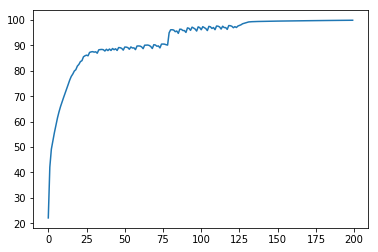

Max score: 99.917.
CPU times: user 6min 57s, sys: 866 ms, total: 6min 58s
Wall time: 6min 58s


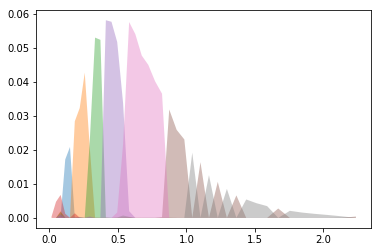

In [36]:
%time w8, m8 = optimize_weights(nbin=8, eta=1., niter=200)

0 24.794164657592773
50 94.96270751953125
100 96.4365005493164
150 96.34480285644531


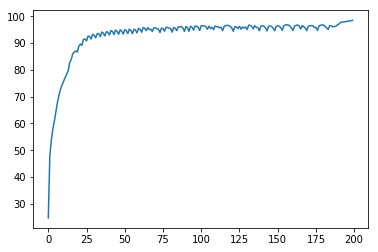

Max score: 98.481.
CPU times: user 10min 56s, sys: 1.28 s, total: 10min 57s
Wall time: 10min 57s


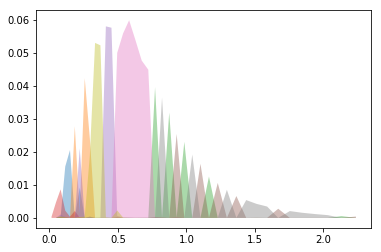

In [37]:
%time w9, m9 = optimize_weights(nbin=9, eta=1., niter=200)